# 4 - Factors

Espen Sirnes  
2024-10-30

Factors are portfolios constructed based on specific characteristics of
assets. For example, Fama and French proposed factors based on company
valuation (over- or under-valuation) and company size.

# Construction of Factors

A standard, simplified method for constructing a factor portfolio
involves creating a long position in the third of assets with the
strongest characteristic (e.g., the most undervalued) and a short
position in the third with the weakest. For instance, the **HML** (High
Minus Low) factor by Fama and French takes a long position in the top
third of companies with the highest market-to-book value and shorts the
bottom third with the lowest.

This results in a portfolio with zero net cost because the long and
short positions offset each other. Hence, there’s no need to subtract
the risk-free rate when calculating returns for factor portfolios.

In Titlon, there are four factors: **SMB**, **HML**, **LIQ**, and
**MOM**, alongside the market factor (the market index).

-   **SMB (Small Minus Big):** The return of small companies minus the
    return of large companies.
-   **HML (High Minus Low):** The return of companies with high
    market-to-book ratios compared to those with low ratios.
-   **LIQ (Liquidity):** The return of the most liquid companies minus
    that of the least liquid.
-   **MOM (Momentum):** The return of companies with high momentum minus
    those with high reversal tendencies.

## Factor Model

The main purpose of factors is to be used in regression analysis, like
the following:

$$
\begin{array}{rl}
x - r_f = \alpha + \beta_M (r_M - r_f)  \\
+\beta_{SMB} \cdot SMB \\
+\beta_{HML} \cdot HML 
+\beta_{LIQ} \cdot LIQ \\
+\beta_{MOM} \cdot MOM
 + \epsilon
\end{array}
$$

This is a multifactor model. If we only include the market factor, the
model reduces to the well-known **CAPM** (Capital Asset Pricing Model).
Adding the additional factors results in a more comprehensive **factor
model**.

# Factors in Portfolio Evaluation

Numerous factors have been proposed in the literature. However, many are
believed to be the result of data mining, so it’s common practice to use
only the most established ones, like those mentioned above, when
evaluating portfolio performance.

The estimated $\alpha$ from the factor model is the most widely
recognized measure of risk-adjusted return. A positive $\alpha$
indicates that a portion of the excess return of $x - r_f$ cannot be
explained by exposure to any of the factors, including the market
factor. This implies that the portfolio has delivered some form of
risk-free excess return.

As in any regression, you can compute the standard error and p-value of
the estimated $\alpha$. This is crucial because, if the $\alpha$ is not
statistically significant, we cannot confidently conclude that it is
different from zero. Therefore, to claim that an asset or portfolio has
truly outperformed the market, its multifactor $\alpha$ should be both
positive and statistically significant.

# Historical Context

This framework is the standard method for determining whether a
portfolio manager has genuinely been skilled or simply benefited from
luck or factor exposures.

The field of finance has, in many ways, been driven by the need to
explain portfolio managers’ overperformance. In the early 20th century,
some managers appeared to consistently outperform the market. The
development of **CAPM** revealed that this was often due to selecting
stocks with high market risk rather than genuine skill. Most of these
managers did not generate CAPM alpha.

For investors seeking higher returns by taking on more market risk,
simply buying more shares (increasing exposure to the market) is
typically more cost-effective than picking the riskiest stocks. The
development of CAPM helped investors make more informed choices.

Similarly, the introduction of factor models showed that some managers
were merely betting on small-cap stocks or undervalued companies to
generate excess returns. When accounting for these factors, much of the
supposed excess return often disappears.

# Coding Challenges:

-   **Challenge 1**: - Download stock data from Titlon for a single
    stock. - Perform a multifactor regression model using the downloaded
    data. - Analyze the significance of the alpha: check whether it is
    statistically significant, and interpret its direction (positive or
    negative). - Provide commentary on what the result implies in terms
    of the stock’s performance relative to the factors.

-   **Challenge 2**: - Download factor data from Titlon and plot the
    performance of these factors alongside the optimal portfolio from
    the previous chapter. - Add each factor as a data point on the
    chart, allowing comparison between the factors and the optimal
    portfolio as well as the portfolio frontier. - Use the following SQL
    query in the Titlon script to retrieve the factor data:
    `sql       SELECT [SMB],[HML],[LIQ],[MOM]           FROM [OSE].[dbo].[factors]           WHERE YEAR([Date]) >= 2016` -
    Plot the performance and visually assess how each factor performs
    relative to the optimal portfolio.

## Tentative answer to Challenge 1:

In the Titlon database, the `equity` table under the OSE tab all ready
contains what we need to solve this. Let us therefore just load the data
from lecture 3, and reduce it to weekly data for the variables we need:

In [1]:
import pandas as pd
# reads the data
df_stocks = pd.read_pickle('output/stocks.df')



# reducding the sample by foccusing on a few stocks of interest
df_stocks = df_stocks[df_stocks['Symbol'].isin(['EQNR','NHY','TEL','YAR'])]

# we capture the ISIN-ticker combinations for later use, to associate stocks with tickers
# We need to use the ISIN in what's follows, because ticker is not a reliable identifier
df_isin_symbol =  df_stocks[['ISIN','Symbol']].drop_duplicates()

# choosing relevant columns
df_stocks = df_stocks[['Symbol', 'Date', 'lnDeltaP', 
                'lnDeltaOSEBX',  'SMB', 'HML', 
                'LIQ', 'MOM', 'NOWA_DayLnrate']]

# defines the indicies
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])
df_stocks = df_stocks.set_index(['Symbol', 'Date'])

# making sure the index is unique and remove nans
df_stocks = df_stocks[~df_stocks.index.duplicated(keep='first')]
df_stocks = df_stocks.dropna(subset=['SMB'])

# Define excess return of stocks and market index
df_stocks['lnDeltaP_rf'] = (df_stocks['lnDeltaP'] 
                                - df_stocks['NOWA_DayLnrate'])
df_stocks['lnDeltaOSEBX_rf'] = (df_stocks['lnDeltaOSEBX'] 
                                - df_stocks['NOWA_DayLnrate'])

# Creating weekly observations
df_stocks_w = df_stocks.groupby('Symbol').resample('W', level='Date').sum()
df_stocks_w

1716 rows × 9 columns

Running the regression for Equinor

In [2]:
import statsmodels.api as sm

# Filter the DataFrame for Symbol = 'EQNR'
df_reg = df_stocks_w.loc['EQNR']

# Define the independent variables (features) and dependent variable (target)
X = df_reg[['lnDeltaOSEBX_rf', 'SMB', 'HML', 'LIQ', 'MOM']]
y = df_reg['lnDeltaP_rf']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(y, X).fit()

# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            lnDeltaP_rf   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     131.7
Date:                Tue, 05 Nov 2024   Prob (F-statistic):           6.56e-84
Time:                        14:55:56   Log-Likelihood:                 981.74
No. Observations:                 429   AIC:                            -1951.
Df Residuals:                     423   BIC:                            -1927.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0006      0.001     

Conclusion, there has been no significant excess return since 2016 for
Equinor.

## Tentative answer to Challenge 2:

First, let us just rerun the last few cells of the previous chapter, in
order to have the previous graph in the memory. That can is done with a
custom function `calc_notebook` in the module `functions,py`in this
directory. `d` contains the variable from those calculations.

Hence the optimal portfolio in this case is

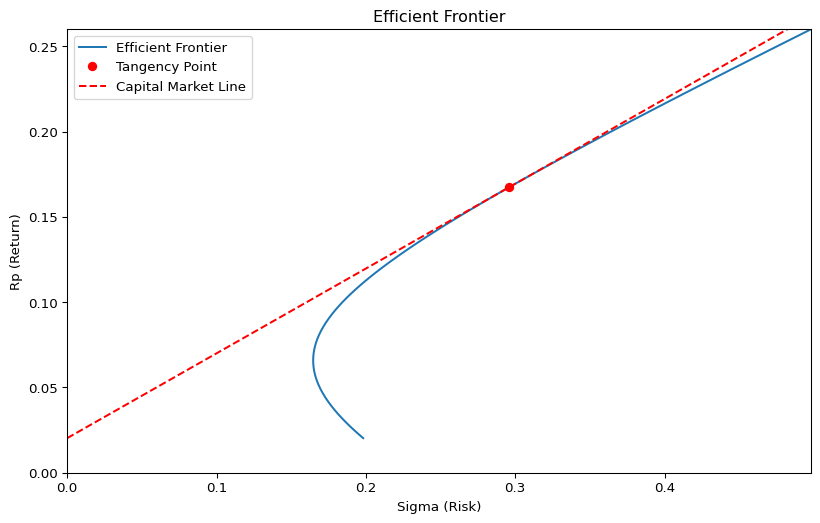

In [3]:
import functions
d = functions.calc_notebook("3-lecture_optport.ipynb", 
              ["read_pickle","get_matrix", "cov_matrix", "A =", 
               "portfolio_front", "ax.plot"])
locals().update(d)

Also, we need data on the factors. We could use the data from the
`equity` table, loaded in lecture 3. However, we want one factor
observation each date, not one for each stock. Downloading the
`factors`model from Titlon is therefore more convenient. We get this by
pasting the script from Titlon below, or you can just paste the username
and password if you want.

If you have all ready run this, you do not need to rerun it, since the
data is stored.

In [4]:
import pandas as pd
#Query script for MySQL client
import pymysql
import os
con = pymysql.connect(host='titlon.uit.no', 
                                user      = "user@account.com",
                                password  = "%VccvGWz5UjtT9sAuU7og",
                                database='OSE')  
crsr=con.cursor()
crsr.execute("SET SESSION MAX_EXECUTION_TIME=60000;")
crsr.execute("""
    SELECT  *
    FROM `OSE`.`factors` 
    WHERE year(`Date`) >= 2016
    ORDER BY `Date`
""")
r=crsr.fetchall()
df=pd.DataFrame(list(r), 
            columns=[i[0] for i in crsr.description])
df


#YOU NEED TO BE CONNECTED TO YOUR INSTITUTION VIA VPN,
# OR BE AT THE INSTITUTION, FOR THIS CODE TO WORK

os.makedirs('output', exist_ok=True)
pd.to_pickle(df,'output/factors.df')

We then loade the saved file and calculate the means and standard
errors, after reducing the frequency from daily to weekly.

In [5]:
import pandas as pd

df = pd.read_pickle('output/factors.df')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df_weekly = df.resample('W').sum()
df_weekly = df_weekly[['SMB', 'HML', 'LIQ', 'MOM']].dropna()
df = df[['SMB', 'HML', 'LIQ', 'MOM']].dropna()
means = df_weekly.mean()*52
std = df_weekly.std()*52**0.5
print(std)
print(means)
df_weekly

SMB    0.145195
HML    0.193652
LIQ    0.160615
MOM    0.216708
dtype: float64
SMB    0.074676
HML    0.145056
LIQ    0.019353
MOM    0.164041
dtype: float64

431 rows × 4 columns

We can then plot the factors in the existing porfolio frontier

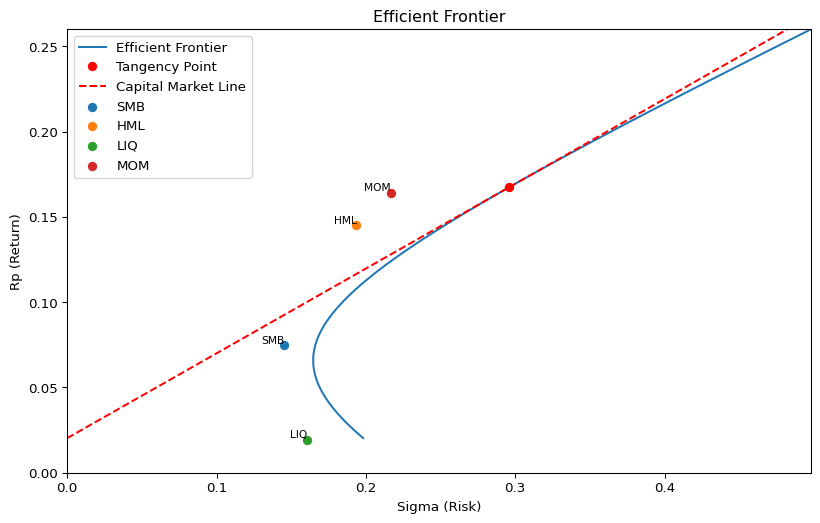

In [6]:
for series in means.index:
        ax.scatter(std[series], means[series], label=series)
        ax.text(std[series], means[series], series, fontsize=8, ha='right', va='bottom')
ax.legend()

fig

Can you construct the optimal portfolio of the stocks and the factors?